In [159]:
import pandas as pd
import numpy as np

import sys
sys.path.insert(1, '../../scripts/')
from s3_support import *

%matplotlib inline

In [2]:
start_date = "2021-04-01"

# load & prep data

## load data

In [3]:
q = "select * from syslog_logs where created>'{}' and message LIKE '%Page view%'".format(start_date)
df = redshift_query_read(q, schema='production')

In [4]:
print("{:,} page view entries".format(len(df)))
print("{:,} page view entries - unique".format(len(df.drop_duplicates())))

16,408,802 page view entries
5,639,161 page view entries - unique


In [5]:
q = "select org, sum(amount) as volume, count(id) as count from transactions where date>'{}' and status='A' group by org".format(start_date)
org_performance = redshift_query_read(q, schema='public')

In [6]:
print("{:,} orgs".format(len(org_performance['org'].unique())))
print("${:,.2f} mean volume per org".format(org_performance['volume'].mean()))
print("{:,.2f} mean count per org".format(org_performance['count'].mean()))

3,297 orgs
$56,626.78 mean volume per org
362.59 mean count per org


## prep log data

### duplicates & columns

In [7]:
df = df.drop_duplicates()

In [8]:
drop_cols = ['count', 'entitytype', 'entity', 'systemid', 'type', 'hidden',
            'access', 'ack']
df = df.drop(drop_cols, axis=1)

In [9]:
df.tail(3)

,id,org,form,systemtype,created,userid,ghost,message
11498520,49714176,445900,445900,0,2021-09-19 20:41:57,1461307,0,Page view: recent_activity/
11498521,49714112,444063,444063,0,2021-09-19 20:41:11,1293274,0,Page view: forms/972700/vt/donation/
11498522,49714096,0,0,0,2021-09-19 20:41:04,0,0,Page view: login


In [10]:
print("{:,} total entries".format(len(df)))
print("{:,} ghost entries".format(len(df[df['ghost']!=0])))
print("{:,} nonghost entries".format(len(df[df['ghost']==0])))

5,639,161 total entries
415,632 ghost entries
5,223,529 nonghost entries


In [11]:
df.groupby('message')['id'].count().reset_index().sort_values('id').head(3)

,message,id
138099,Page view: forms/976110/events/837071/fields/2...,1
179786,Page view: invoice/12894857,1
179787,Page view: invoice/12910135,1


### standardizing & categorizing url's

In [12]:
def canonize_url(x):
    if 'Page view: reset/' in x:
        return 'Page view: reset/[ID]'
    elif 'Page view: statements/settlements/daily/' in x:
        return 'Page view: statements/settlements/daily/[D]'
    else:
        return x

df['message'] = df['message'].str.replace('\/\d+\/', '/[ID]/', regex=True)
df['message'] = df['message'].str.replace('\/\d+$', '/[ID]', regex=True)
df['message'] = df['message'].apply(canonize_url)

In [13]:
def categorize_url(x):
    if '/cms/' in x or '/cms-resources/' in x or 'cms-upload' in x:
        return 'CMS'
    elif 'forms/[ID]/participant' in x or ': donation/import' in x or 'forms/[ID]/participants/' in x or ': statements/' in x or ': donors/' in x or ': reports/' in x or 'transaction/[ID]' in x or 'donors/[ID]' in x or 'forms/[ID]/donors/' in x:
        return 'Reporting'
    elif ': vt' in x or '/vt/' in x:
        return 'VT'
    elif 'forms/[ID]/events' in x:
        return 'Events'
    elif '/teams/' in x or 'forms/[ID]/team' in x:
        return 'Teams'
    elif ': sms/' in x:
        return 'SMS'
    elif '/advancedfields/' in x or 'forms/[ID]/fields' in x or 'forms/[ID]/systemfields' in x:
        return 'Fields'
    elif x in ['Page view: forms/', 'Page view: forms/[ID]/'] or 'chart_new/' in x or 'recent_activity/' in x or 'login/' in x:
        return 'Dashboard'
    elif 'forms/[ID]/amounts' in x:
        return 'Amounts'
    elif 'forms/[ID]/wording' in x or 'forms/[ID]/resources' in x or 'forms/[ID]/upload' in x or ': notifications' in x or 'forms/[ID]/receipts' in x or 'forms/[ID]/email/templates/' in x or 'forms/[ID]/notifications' in x:
        return 'Content'
    elif ': pricing' in x or ': settings/' in x or 'forms/[ID]/settings' in x or 'forms/clone' in x:
        return 'Settings'
    elif 'forms/[ID]/categories' in x:
        return 'Categories'
    elif 'forms/[ID]/products/' in x:
        return 'Products'
    elif 'forms/[ID]/sponsors/' in x:
        return 'Sponsors'
    elif ': users/' in x:
        return 'Users'
    elif 'forms/[ID]/kiosks' in x:
        return 'Kiosks'
    elif 'forms/[ID]/restrictions' in x:
        return 'Restrictions'
    elif 'forms/[ID]/classification' in x:
        return 'Classifications'
    elif 'forms/[ID]/items' in x:
        return 'Auctions' # verify
    elif 'forms/[ID]/promos' in x:
        return 'Promos'
    elif 'forms/[ID]/dedications' in x:
        return 'Dedications'
    elif 'forms/[ID]/welcome' in x:
        return 'Welcome'
    elif 'forms/[ID]/social' in x:
        return 'Social'
    elif ': api' in x:
        return 'API'
    elif 'forms/[ID]/givi/' in x:
        return 'Givi'
    elif 'forms/[ID]/campaign' in x:
        return 'Campaigns'
    elif 'forms/[ID]/pledges' in x:
        return 'Pledges'
    elif ': recurring' in x:
        return 'Recurring'
    elif ': signup' in x:
        return 'Signup'
    elif 'forms/[ID]/badge' in x:
        return 'Badges'
    elif 'forms/[ID]/goals' in x:
        return 'Goals'
    elif 'forms/[ID]/products' in x:
        return 'Products'
    else:
        return None
    
df['url cat'] = df['message'].apply(categorize_url)

In [14]:
print("{} untagged urls".format(len(df[df['url cat'].isnull()&~df['message'].isin(['Page view: ', 'Page view: login'])]['message'].unique())))
df[df['url cat'].isnull()&~df['message'].isin(['Page view: ', 'Page view: login'])]['message'].unique()

42 untagged urls


array(['Page view: widgets/', 'Page view: reset/[ID]',
       'Page view: forms/[ID]/update/', 'Page view: receipts/[ID]/',
       'Page view: receipts/', 'Page view: support/',
       'Page view: widgets/update/', 'Page view: welcome',
       'Page view: chart/', 'Page view: 404/', 'Page view: widgets/ajax/',
       'Page view: formtags/add/', 'Page view: forms/[ID]/unghost/',
       'Page view: organizations/', 'Page view: widgets/config/',
       'Page view: formtags/', 'Page view: forms/[ID]/inviteparticipant/',
       'Page view: invites', 'Page view: authenticate',
       'Page view: switch/', 'Page view: forms/[ID]/flagged/',
       'Page view: receipts/update/', 'Page view: donation/verify',
       'Page view: forms/[ID]/landing/edit',
       'Page view: forms/[ID]/guides/', 'Page view: switch',
       'Page view: donation/facebookimport/',
       'Page view: forms/[ID]/guides/[ID]', 'Page view: users',
       'Page view: invoice/[ID]', 'Page view: receipts/upload/',
       'Pa

In [15]:
df.groupby('url cat')['org'].count()

url cat
API                   1728
Amounts              39147
Auctions            155002
Badges                3184
CMS                 327578
Campaigns             6828
Categories            9135
Classifications       6343
Content              85099
Dashboard          2954637
Dedications           6143
Events              191740
Fields               22544
Givi                  4741
Goals                 3649
Kiosks                1146
Pledges               5316
Products             46656
Promos                7506
Recurring            26678
Reporting           929427
Restrictions         14257
SMS                   9389
Settings             60015
Signup                6683
Social                7649
Sponsors             28316
Teams                35312
Users                28269
VT                  217013
Welcome                646
Name: org, dtype: int64

In [68]:
# isolate categories with the least ongoing management functionality
url_cat_features = ['Amount', 'Badges', 'Categories', 'Campaigns', 
                    'Events', 'Fields', 'Goals', 'Promos', 
                    'Restrictions', 'Social']
cat_feature_orgs = df[df['url cat'].isin(url_cat_features)]['org'].unique()

# building org page view list

In [69]:
org_pageviews = df.groupby(['org', 'message'])['id'].count().reset_index()
org_pageviews.columns = ['org', 'url', 'views']

In [70]:
org_pageviews[org_pageviews['org']!=0].head(3)

,org,url,views
34,6,Page view:,600
35,6,Page view: chart_new/,2104
36,6,Page view: donors/,3


In [71]:
print("{:,} orgs".format(len(org_pageviews['org'].unique())))
print("{:,} urls".format(len(org_pageviews['url'].unique())))
print("{:,.2f} URL's per org".format(org_pageviews.groupby('org')['url'].count().mean()))
print("{:,.2f} views per org".format(org_pageviews.groupby('org')['views'].sum().mean()))

3,625 orgs
595 urls
38.22 URL's per org
1,555.63 views per org


# exploration

## page views X performance

In [72]:
org_performance['org'] = org_performance['org'].astype(int)
org_pageviews['org'] = org_pageviews['org'].astype(int)

In [73]:
def get_org_volume(org):
    if len(org_performance[org_performance['org']==org]) > 0:
        return org_performance[org_performance['org']==org]['volume'].iloc[0]
    else:
        return 0.0

def get_org_count(org):
    if len(org_performance[org_performance['org']==org]) > 0:
        org_performance[org_performance['org']==org]['count'].iloc[0]
    else:
        return 0

## urls X performance

In [74]:
org_pageview_matrix = org_pageviews.pivot(index='org', columns='url', values='views').reset_index().fillna(0)
org_pageview_matrix['volume'] = org_pageview_matrix['org'].apply(get_org_volume).fillna(0).astype(float)
org_pageview_matrix['count'] = org_pageview_matrix['org'].apply(get_org_count).fillna(0).astype(int)

In [75]:
org_pageview_matrix['count'].value_counts()

0    3625
Name: count, dtype: int64

In [76]:
corrs = org_pageview_matrix.corr()[['volume', 'count']].reset_index().sort_values('volume')

In [77]:
corrs.drop('count', axis=1, inplace=True)

In [78]:
print(corrs.head())
print()
print(corrs.tail(20))

url                                     url    volume
537       Page view: signup/documents/sign/ -0.010898
532  Page view: signup/agreement/documents/ -0.010566
538     Page view: signup/documents/upload/ -0.010489
534     Page view: signup/agreement/widget/ -0.010465
539         Page view: signup/organization/ -0.010116

url                                                url    volume
169  Page view: forms/[ID]/cms/standardregistration...  0.819847
421                 Page view: reports/export-history/  0.824653
125      Page view: forms/[ID]/cms/paymentdetails/edit  0.828206
379           Page view: recurring/[ID]/personal/edit/  0.841910
375            Page view: recurring/[ID]/billing/edit/  0.845929
25               Page view: forms/[ID]/advancedfields/  0.874360
26           Page view: forms/[ID]/advancedfields/[ID]  0.894018
149  Page view: forms/[ID]/cms/registrationclassifi...  0.910438
18                   Page view: donors/[ID]/recurring/  0.928489
168  Page view: forms/[ID

In [79]:
corrs[~corrs['url'].str.contains('/cms/')&~corrs['url'].str.contains(': reports/')].tail(20)

url,url,volume
320,Page view: forms/[ID]/systemfields/,0.541737
374,Page view: recurring/[ID]/amount/edit/,0.553881
14,Page view: donors/,0.569777
19,Page view: donors/[ID]/transaction/,0.607211
564,Page view: transaction/[ID]/donation/edit/,0.681721
582,Page view: vt/[ID],0.692515
16,Page view: donors/[ID]/,0.703797
17,Page view: donors/[ID]/contact/,0.742722
373,Page view: recurring/[ID]/,0.769383
372,Page view: recurring/[ID],0.798906


## category X performance

In [80]:
cat_pageviews = df.groupby(['org', 'url cat'])['id'].count().reset_index()
cat_pageviews.columns = ['org', 'category', 'views']

In [81]:
cat_pageview_matrix = cat_pageviews.pivot(index='org', columns='category', values='views').reset_index().fillna(0)
cat_pageview_matrix['volume'] = cat_pageview_matrix['org'].apply(get_org_volume).fillna(0).astype(float)
cat_pageview_matrix['count'] = cat_pageview_matrix['org'].apply(get_org_count).fillna(0).astype(int)

In [82]:
corrs = cat_pageview_matrix.corr()[['volume', 'count']].reset_index().sort_values('volume')

In [83]:
corrs.drop('count', axis=1, inplace=True)

In [84]:
corrs[corrs['volume'].abs()>0.1]

category,category,volume
30,VT,0.117445
12,Events,0.128144
24,Settings,0.153613
5,CMS,0.182896
17,Pledges,0.202432
2,Amounts,0.281733
22,Restrictions,0.347313
9,Content,0.372309
21,Reporting,0.524087
13,Fields,0.736834


# specific systems/features

## cms

In [85]:
org_cms_pageviews = org_pageviews[org_pageviews['url'].str.contains('/cms/')].copy()

In [86]:
print("{:,} total page view entries".format(len(org_pageviews)))
print("{:,} total cms page view entries".format(len(org_cms_pageviews)))

138,542 total page view entries
22,610 total cms page view entries


In [87]:
org_cms_pageviews = org_cms_pageviews.groupby('org')['views'].sum().reset_index()
org_cms_pageviews.columns = ['org', 'cms views']

org_cms_pageviews['count'] = org_cms_pageviews['org'].apply(get_org_count).fillna(0).astype(int)
org_cms_pageviews['volume'] = org_cms_pageviews['org'].apply(get_org_volume).fillna(0).astype(float)

In [88]:
org_cms_pageviews['views_bucket'] = pd.qcut(org_cms_pageviews['cms views'], q=[0, 0.2, 0.4, 0.6, 0.8, 1.])
org_cms_pageviews.groupby('views_bucket')['volume'].agg(['mean', 'median', 'count']).sort_values('views_bucket').reset_index()

,views_bucket,mean,median,count
0,"(0.999, 9.0]",34575.269785,6042.700,325
1,"(9.0, 35.0]",35503.428906,6611.750,329
2,"(35.0, 96.0]",44376.835348,16389.800,316
3,"(96.0, 268.0]",50573.962181,16977.580,321
4,"(268.0, 6228.0]",303311.191832,32996.615,322


AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


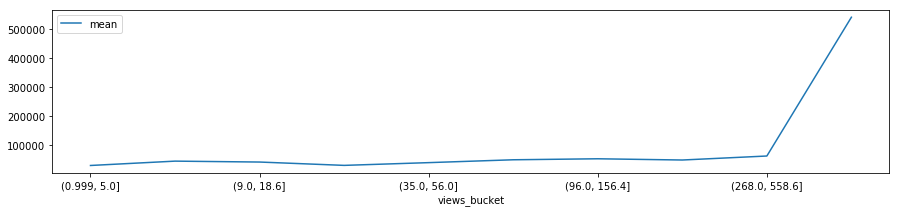

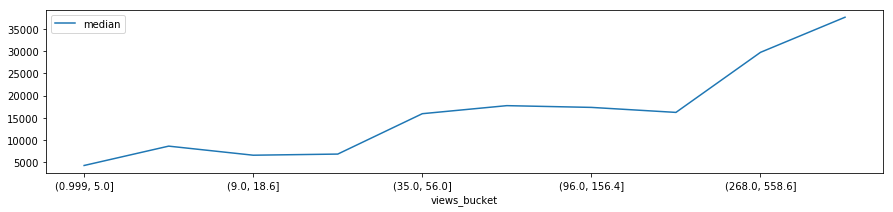

In [89]:
org_cms_pageviews['views_bucket'] = pd.qcut(org_cms_pageviews['cms views'], q=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.], duplicates='drop')

print(org_cms_pageviews.groupby('views_bucket')['volume'].agg(['mean', 'median', 'count']).sort_values('views_bucket').reset_index().plot(x='views_bucket', y='mean', figsize=(15,3)))
print(org_cms_pageviews.groupby('views_bucket')['volume'].agg(['mean', 'median', 'count']).sort_values('views_bucket').reset_index().plot(x='views_bucket', y='median', figsize=(15,3)))

### weekly visits

In [90]:
org_cms_pageviews = df[df['url cat']=='CMS']
org_cms_pageviews['created_year'] = org_cms_pageviews['created'].dt.year
org_cms_pageviews['created_week'] = org_cms_pageviews['created'].dt.weekofyear
org_cms_pageviews['created_week'] = org_cms_pageviews[['created_year', 'created_week']].apply(lambda x: "{}-{}".format(x['created_year'], x['created_week']), axis=1)
org_cms_pageviews.drop('created_year', axis=1, inplace=True)
org_cms_pageviews.tail(3)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

,id,org,form,systemtype,created,userid,ghost,message,url cat,created_week
11498499,49714576,447550,447550,0,2021-09-19 20:50:49,1600122,1600122,Page view: forms/[ID]/cms/formconfirmation/edit,CMS,2021-37
11498502,49714528,447550,447550,0,2021-09-19 20:49:42,1600122,1600122,Page view: forms/[ID]/cms/landingpage/edit,CMS,2021-37
11498504,49714496,447550,447550,0,2021-09-19 20:49:07,1600122,1600122,Page view: forms/[ID]/cms/home/,CMS,2021-37


In [91]:
org_cms_weeks = org_cms_pageviews.groupby(['org'])['created_week'].nunique().reset_index()
org_cms_weeks.columns = ['org', 'cms_weeks']

org_cms_weeks['count'] = org_cms_weeks['org'].apply(get_org_count).fillna(0).astype(int)
org_cms_weeks['volume'] = org_cms_weeks['org'].apply(get_org_volume).fillna(0).astype(float)

In [92]:
org_cms_weeks['views_bucket'] = pd.qcut(org_cms_weeks['cms_weeks'], q=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.], duplicates='drop')
org_cms_weeks.groupby('views_bucket')['volume'].agg(['mean', 'median', 'count']).sort_values('views_bucket').reset_index()

,views_bucket,mean,median,count
0,"(0.999, 2.0]",30240.243557,6601.160,835
1,"(2.0, 3.0]",43825.754769,15646.160,216
2,"(3.0, 4.0]",51617.417083,20129.020,144
3,"(4.0, 5.0]",48126.250708,23188.930,113
4,"(5.0, 8.0]",104741.394076,31159.065,184
5,"(8.0, 12.0]",694054.207355,65896.040,121


Weekly cms visits
----------------------------------------
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


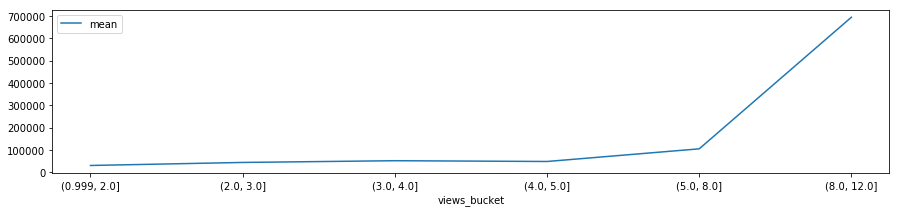

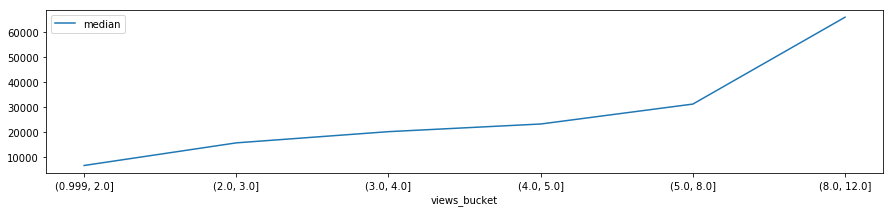

In [93]:
print("Weekly cms visits")
print("-"*40)
print(org_cms_weeks.groupby('views_bucket')['volume'].agg(['mean', 'median', 'count']).sort_values('views_bucket').reset_index().plot(x='views_bucket', y='mean', figsize=(15,3)))
print(org_cms_weeks.groupby('views_bucket')['volume'].agg(['mean', 'median', 'count']).sort_values('views_bucket').reset_index().plot(x='views_bucket', y='median', figsize=(15,3)))

There is a clear trend toward a positive correlation between CMS visits and performance. This correlation holds between absolute page visits and weekly aggregates. This would lead me to believe that the visits are repeated over periods of time, not single instances of setting up a page and not returning. The given time period for this data begins in April 2021 and the top performing group visited CMS at least once over 8 to 12 weeks during this 5 month time span. This top performing group out performed the remainder by a significant margin.

This confirms, in my opinion, that a single setup is insufficient to realize the correlated gains.

#### what is the performance difference between 0, 1, 1+ CMS visits

In [154]:
non_cms_orgs = org_performance[~org_performance['org'].isin(org_cms_weeks['org'].unique())]

print("No CMS visit week:")
print("\tmean count: ${:,.2f}".format(non_cms_orgs['volume'].mean()))
print("\tmedian count: ${:,.2f}".format(non_cms_orgs['volume'].median()))
print("1 CMS visit week:")
print("\tmean count: ${:,.2f}".format(org_cms_weeks[org_cms_weeks['cms_weeks']==1]['volume'].mean()))
print("\tmedian count: ${:,.2f}".format(org_cms_weeks[org_cms_weeks['cms_weeks']==1]['volume'].median()))
print("> 1 CMS visit week:")
print("\tmean count: ${:,.2f}".format(org_cms_weeks[org_cms_weeks['cms_weeks']>1]['volume'].mean()))
print("\tmedian count: ${:,.2f}".format(org_cms_weeks[org_cms_weeks['cms_weeks']>1]['volume'].median()))

No CMS visit week:
	mean count: $19,723.54
	median count: $3,332.75
1 CMS visit week:
	mean count: $31,855.82
	median count: $4,972.00
> 1 CMS visit week:
	mean count: $125,507.12
	median count: $20,974.10


In [161]:
means = []
medians = []
for i in range(12):
    if i == 0:
        continue
    if i == 1:
        no_visits_mean = non_cms_orgs['volume'].mean()
        no_visits_median = non_cms_orgs['volume'].median()
        one_visit_mean = org_cms_weeks[org_cms_weeks['cms_weeks']==1]['volume'].mean()
        one_visit_median = org_cms_weeks[org_cms_weeks['cms_weeks']==1]['volume'].median()
        
        print("1 visit:")
        print("\tmean: ${:,.2f}".format(one_visit_mean - no_visits_mean))
        print("\tmedian: ${:,.2f}".format(one_visit_median - no_visits_median))
        
        means.append(one_visit_mean - no_visits_mean)
        medians.append(one_visit_median - no_visits_median)
    else:
        low_visits_mean = org_cms_weeks[org_cms_weeks['cms_weeks']==i-1]['volume'].mean()
        low_visits_median = org_cms_weeks[org_cms_weeks['cms_weeks']==i-1]['volume'].median()
        high_visit_mean = org_cms_weeks[org_cms_weeks['cms_weeks']==i]['volume'].mean()
        high_visit_median = org_cms_weeks[org_cms_weeks['cms_weeks']==i]['volume'].median()
        
        print("{} visits:".format(i))
        print("\tmean: ${:,.2f}".format(high_visit_mean - low_visits_mean))
        print("\tmedian: ${:,.2f}".format(high_visit_median - low_visits_median))
        
        means.append(high_visit_mean - low_visits_mean)
        medians.append(high_visit_median - low_visits_median)
        
print("All:")
print("\tmean: ${:,.2f}".format(np.mean(means)))
print("\tmedian: ${:,.2f}".format(np.mean(medians)))

1 visit:
	mean: $12,132.28
	median: $1,639.25
2 visits:
	mean: $-4,750.01
	median: $5,196.25
3 visits:
	mean: $16,719.95
	median: $5,477.91
4 visits:
	mean: $7,791.66
	median: $4,482.86
5 visits:
	mean: $-3,491.17
	median: $3,059.91
6 visits:
	mean: $62,349.24
	median: $3,112.07
7 visits:
	mean: $-4,240.10
	median: $-2,935.89
8 visits:
	mean: $-10,164.40
	median: $27,550.35
9 visits:
	mean: $8,866.80
	median: $19,840.17
10 visits:
	mean: $-13,901.89
	median: $-30,584.54
11 visits:
	mean: $84,889.35
	median: $23,493.58
All:
	mean: $14,200.16
	median: $5,484.72


# reports

In [95]:
org_reports_pageviews = org_pageviews[org_pageviews['url'].str.contains(': reports/')].copy()

In [96]:
print("{:,} total page view entries".format(len(org_pageviews)))
print("{:,} total reports page view entries".format(len(org_reports_pageviews)))

138,542 total page view entries
22,883 total reports page view entries


In [97]:
org_reports_pageviews = org_reports_pageviews.groupby('org')['views'].sum().reset_index()
org_reports_pageviews.columns = ['org', 'reports views']

org_reports_pageviews['count'] = org_reports_pageviews['org'].apply(get_org_count).fillna(0).astype(int)
org_reports_pageviews['volume'] = org_reports_pageviews['org'].apply(get_org_volume).fillna(0).astype(float)

In [98]:
org_reports_pageviews['views_bucket'] = pd.qcut(org_reports_pageviews['reports views'], q=[0, 0.2, 0.4, 0.6, 0.8, 1.])
org_reports_pageviews.groupby('views_bucket')['volume'].agg(['mean', 'median', 'count']).sort_values('views_bucket').reset_index()

,views_bucket,mean,median,count
0,"(0.999, 8.0]",3561.850333,50.000,601
1,"(8.0, 29.0]",11122.944096,2844.645,520
2,"(29.0, 86.0]",23644.023921,8035.370,556
3,"(86.0, 248.6]",39481.348324,21822.000,549
4,"(248.6, 19717.0]",252346.144183,61364.360,557


AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


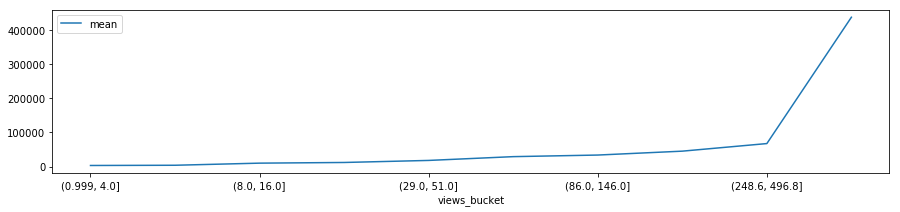

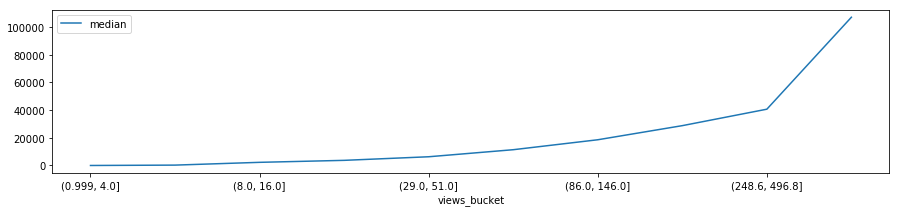

In [99]:
org_reports_pageviews['views_bucket'] = pd.qcut(org_reports_pageviews['reports views'], q=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.], duplicates='drop')

print(org_reports_pageviews.groupby('views_bucket')['volume'].agg(['mean', 'median', 'count']).sort_values('views_bucket').reset_index().plot(x='views_bucket', y='mean', figsize=(15,3)))
print(org_reports_pageviews.groupby('views_bucket')['volume'].agg(['mean', 'median', 'count']).sort_values('views_bucket').reset_index().plot(x='views_bucket', y='median', figsize=(15,3)))

### weekly visits

In [100]:
org_rep_pageviews = df[df['url cat']=='Reporting'].copy()
org_rep_pageviews['created_year'] = org_rep_pageviews['created'].dt.year
org_rep_pageviews['created_week'] = org_rep_pageviews['created'].dt.weekofyear
org_rep_pageviews['created_week'] = org_rep_pageviews[['created_year', 'created_week']].apply(lambda x: "{}-{}".format(x['created_year'], x['created_week']), axis=1)
org_rep_pageviews.drop('created_year', axis=1, inplace=True)
org_rep_pageviews.tail(3)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

,id,org,form,systemtype,created,userid,ghost,message,url cat,created_week
11498506,49714448,445942,445942,0,2021-09-19 20:48:14,1449703,0,Page view: reports/event-registration/search/,Reporting,2021-37
11498511,49714368,444481,444481,0,2021-09-19 20:45:25,1330064,0,Page view: reports/transaction/search/,Reporting,2021-37
11498513,49714320,446016,446016,0,2021-09-19 20:44:06,1454228,0,Page view: reports/auction-purchased-items/sea...,Reporting,2021-37


In [101]:
org_rep_weeks = org_rep_pageviews.groupby(['org'])['created_week'].nunique().reset_index()
org_rep_weeks.columns = ['org', 'reporting_weeks']

org_rep_weeks['count'] = org_rep_weeks['org'].apply(get_org_count).fillna(0).astype(int)
org_rep_weeks['volume'] = org_rep_weeks['org'].apply(get_org_volume).fillna(0).astype(float)

In [102]:
org_rep_weeks['views_bucket'] = pd.qcut(org_rep_weeks['reporting_weeks'], q=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.], duplicates='drop')
org_rep_weeks.groupby('views_bucket')['volume'].agg(['mean', 'median', 'count']).sort_values('views_bucket').reset_index()

,views_bucket,mean,median,count
0,"(0.999, 2.0]",4999.030974,219.000,1057
1,"(2.0, 3.0]",10832.271849,2729.000,265
2,"(3.0, 5.0]",17691.260150,7248.000,399
3,"(5.0, 6.0]",23747.785872,11510.825,172
4,"(6.0, 8.0]",35244.793096,18039.530,281
5,"(8.0, 10.0]",43948.082517,28251.210,298
6,"(10.0, 12.0]",242930.345470,61553.250,585


Weekly reporting visits
----------------------------------------
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


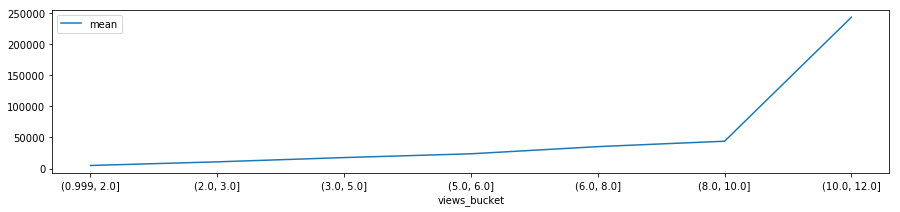

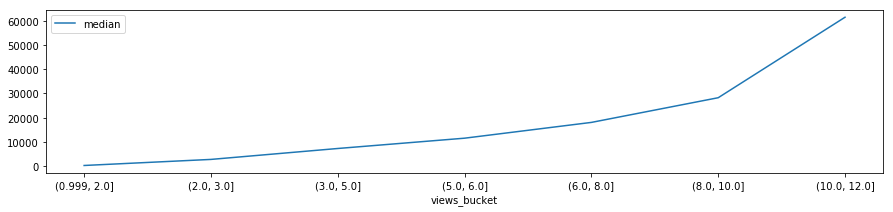

In [103]:
print("Weekly reporting visits")
print("-"*40)
print(org_rep_weeks.groupby('views_bucket')['volume'].agg(['mean', 'median', 'count']).sort_values('views_bucket').reset_index().plot(x='views_bucket', y='mean', figsize=(15,3)))
print(org_rep_weeks.groupby('views_bucket')['volume'].agg(['mean', 'median', 'count']).sort_values('views_bucket').reset_index().plot(x='views_bucket', y='median', figsize=(15,3)))

### specific reporting pages

In [174]:
org_rep_pages = df[df['url cat']=='Reporting'].copy()
org_rep_pages = org_rep_pages.groupby(['org', 'message'])['id'].count().reset_index()
org_rep_pages.columns = ['org', 'url', 'count']

org_rep_pages['count'] = org_rep_pages['org'].apply(get_org_count).fillna(0).astype(int)
org_rep_pages['volume'] = org_rep_pages['org'].apply(get_org_volume).fillna(0).astype(float)

In [183]:
def cat_reporting_page(url):
    if '/mappings/' in url:
        return 'Mappings'
    elif 'donors/[ID]' in url:
        return 'Donors'
    elif 'export' in url:
        return 'Exports'
    elif '/invoice/' in url:
        return 'Invoices'
    elif 'reports/' in url:
        return 'Reports'
    elif 'transaction/[ID]' in url:
        return 'Transactions'
    else:
        return None

org_rep_pages['rep cat'] = org_rep_pages['url'].apply(cat_reporting_page)

In [186]:
for _, r in org_rep_pages[org_rep_pages['org']!=0].groupby('rep cat')['volume'].agg(['mean', 'median']).reset_index().sort_values('mean', ascending=True).iterrows():
    print("| {} | ${:,.2f} | ${:,.2f} | ".format(r['rep cat'], r['mean'], r['median']))

| Reports | $162,117.86 | $23,216.75 | 
| Transactions | $216,631.96 | $25,859.00 | 
| Mappings | $219,653.64 | $28,657.55 | 
| Donors | $304,145.16 | $37,866.82 | 
| Exports | $305,002.92 | $27,867.00 | 
| Invoices | $24,241,025.60 | $18,726.60 | 


In [188]:
org_rep_pages[org_rep_pages['org']!=0].groupby('rep cat')['org'].nunique()

rep cat
Donors           690
Exports          961
Invoices           3
Mappings         479
Reports         2741
Transactions    2022
Name: org, dtype: int64

## fields

fields has a strong correlation by URL category with performance. we want to find

1. what are the mean & median performance for fields by visit? do repeat visits correlate with performance? __no__
2. are repeat visits over various time periods correlated with performance? do well performing orgs visit multiple occasions, implying adjustment, or is a single visit sufficient?

In [104]:
org_fields_pageviews = df[df['url cat']=='Fields'].copy()

print("{:,} ({:.2f}%) entries".format(len(org_fields_pageviews), (len(org_fields_pageviews) / len(df)) * 100.))
print("{:,} ({:.2f}%) orgs".format(len(org_fields_pageviews['org'].unique()), (len(org_fields_pageviews['org'].unique()) / len(df['org'].unique())) * 100.))

22,544 (0.40%) entries
1,226 (33.82%) orgs


In [105]:
org_fields_grpd = org_fields_pageviews.groupby('org')['id'].count().reset_index()
org_fields_grpd.columns = ['org', 'pageviews']

org_fields_grpd['count'] = org_reports_pageviews['org'].apply(get_org_count).fillna(0).astype(int)
org_fields_grpd['volume'] = org_reports_pageviews['org'].apply(get_org_volume).fillna(0).astype(float)

In [106]:
org_fields_grpd['views_bucket'] = pd.qcut(org_fields_grpd['pageviews'], q=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.], duplicates='drop')
org_fields_grpd.groupby('views_bucket')['volume'].agg(['mean', 'median', 'count']).sort_values('views_bucket').reset_index()

,views_bucket,mean,median,count
0,"(0.999, 2.0]",49795.961901,17290.67,342
1,"(2.0, 3.0]",68271.598316,15406.00,95
2,"(3.0, 4.0]",104607.595056,13226.00,89
3,"(4.0, 6.0]",46243.168957,18166.07,115
4,"(6.0, 9.0]",112496.851783,19989.74,129
5,"(9.0, 13.0]",57124.116667,21053.75,93
6,"(13.0, 21.0]",76574.892358,18337.81,123
7,"(21.0, 41.0]",75458.587731,10363.98,119
8,"(41.0, 1389.0]",54127.966777,10747.30,121


AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


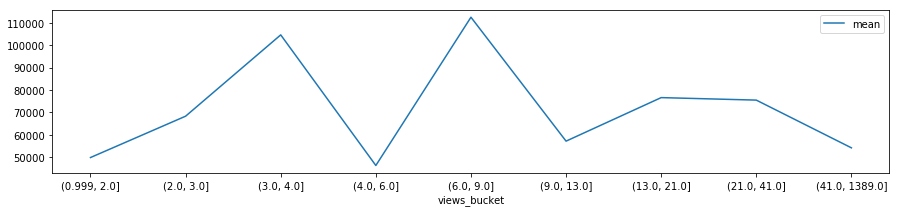

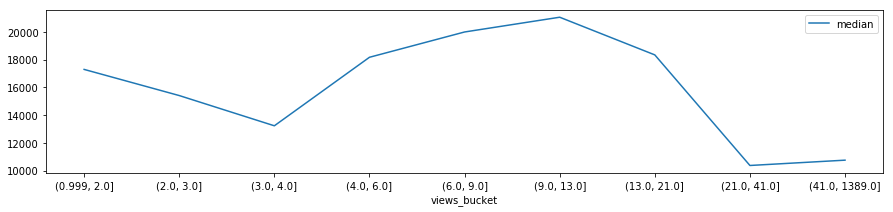

In [107]:
print(org_fields_grpd.groupby('views_bucket')['volume'].agg(['mean', 'median', 'count']).sort_values('views_bucket').reset_index().plot(x='views_bucket', y='mean', figsize=(15,3)))
print(org_fields_grpd.groupby('views_bucket')['volume'].agg(['mean', 'median', 'count']).sort_values('views_bucket').reset_index().plot(x='views_bucket', y='median', figsize=(15,3)))

There doesn't appear to be a strong correlation between increased visits and performance

In [108]:
org_fields_pageviews['created_week'] = org_fields_pageviews['created'].dt.weekofyear
org_fields_pageviews['created_year'] = org_fields_pageviews['created'].dt.year
org_fields_pageviews['created_week'] = org_fields_pageviews[['created_year', 'created_week']].apply(lambda x: "{}-{}".format(x['created_year'], x['created_week']), axis=1)
org_fields_pageviews.drop('created_year', axis=1, inplace=True)
org_fields_pageviews.tail(3)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  """Entry point for launching an IPython kernel.
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#

,id,org,form,systemtype,created,userid,ghost,message,url cat,created_week
11497760,49740989,447185,447185,0,2021-09-20 08:54:03,1566582,0,Page view: forms/[ID]/fields/[ID],Fields,2021-38
11497798,49740317,445462,445462,0,2021-09-20 08:47:41,1421113,0,Page view: forms/[ID]/fields/,Fields,2021-38
11498211,49725118,447390,447390,0,2021-09-20 01:35:57,1587227,0,Page view: forms/[ID]/advancedfields/,Fields,2021-38


In [109]:
org_fields_weeks = org_fields_pageviews.groupby(['org'])['created_week'].nunique().reset_index()
org_fields_weeks.columns = ['org', 'fields_weeks']

org_fields_weeks['count'] = org_fields_weeks['org'].apply(get_org_count).fillna(0).astype(int)
org_fields_weeks['volume'] = org_fields_weeks['org'].apply(get_org_volume).fillna(0).astype(float)

In [110]:
org_fields_weeks['views_bucket'] = pd.qcut(org_fields_weeks['fields_weeks'], q=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.], duplicates='drop')
org_fields_weeks.groupby('views_bucket')['volume'].agg(['mean', 'median', 'count']).sort_values('views_bucket').reset_index()

,views_bucket,mean,median,count
0,"(0.999, 2.0]",41142.707822,13198.25,808
1,"(2.0, 3.0]",84488.399480,29961.00,173
2,"(3.0, 5.0]",74946.508365,36799.97,159
3,"(5.0, 12.0]",925766.082558,69055.88,86


Weekly fields visits
----------------------------------------
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


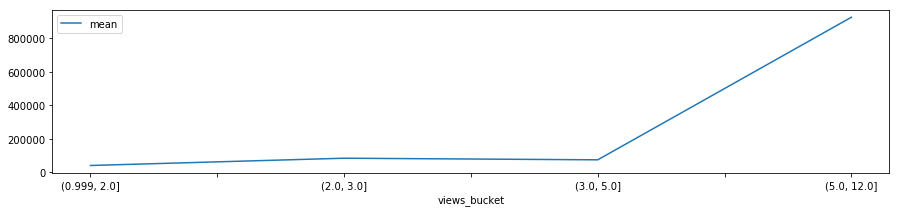

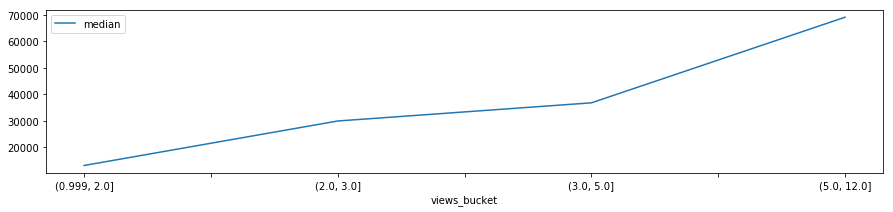

In [111]:
print("Weekly fields visits")
print("-"*40)
print(org_fields_weeks.groupby('views_bucket')['volume'].agg(['mean', 'median', 'count']).sort_values('views_bucket').reset_index().plot(x='views_bucket', y='mean', figsize=(15,3)))
print(org_fields_weeks.groupby('views_bucket')['volume'].agg(['mean', 'median', 'count']).sort_values('views_bucket').reset_index().plot(x='views_bucket', y='median', figsize=(15,3)))

AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


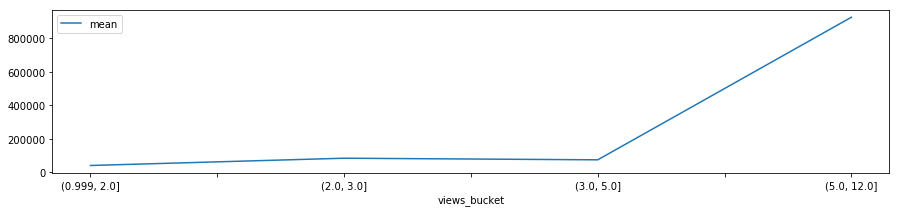

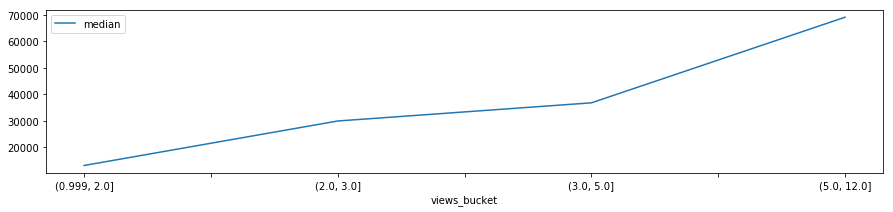

In [112]:
print(org_fields_weeks.groupby('views_bucket')['volume'].agg(['mean', 'median', 'count']).sort_values('views_bucket').reset_index().plot(x='views_bucket', y='mean', figsize=(15,3)))
print(org_fields_weeks.groupby('views_bucket')['volume'].agg(['mean', 'median', 'count']).sort_values('views_bucket').reset_index().plot(x='views_bucket', y='median', figsize=(15,3)))

There is a significant imbalance in the higher visits set but the trend does look very stable to indicate that visits to the fields management positively correlates with performance

In [113]:
org_fields_weeks['views_bucket'] = pd.qcut(org_fields_weeks['fields_weeks'], q=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.], duplicates='drop')
org_fields_weeks.groupby('views_bucket')['volume'].agg(['mean', 'median', 'count']).sort_values('views_bucket').reset_index()

,views_bucket,mean,median,count
0,"(0.999, 2.0]",41142.707822,13198.25,808
1,"(2.0, 3.0]",84488.399480,29961.00,173
2,"(3.0, 5.0]",74946.508365,36799.97,159
3,"(5.0, 12.0]",925766.082558,69055.88,86


## receipts

In [114]:
org_receipts_pageviews = org_pageviews[org_pageviews['url'].str.contains(': receipts/')].copy()

In [115]:
rec_grpd = org_receipts_pageviews.groupby('org')['views'].sum().reset_index()

rec_grpd['count'] = rec_grpd['org'].apply(get_org_count).fillna(0).astype(int)
rec_grpd['volume'] = rec_grpd['org'].apply(get_org_volume).fillna(0).astype(float)

In [116]:
rec_grpd['views_bucket'] = pd.qcut(rec_grpd['views'], q=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.], duplicates='drop')
rec_grpd.groupby('views_bucket')['volume'].agg(['mean', 'median', 'count']).sort_values('views_bucket').reset_index()

,views_bucket,mean,median,count
0,"(0.999, 2.0]",55424.269487,13549.680,487
1,"(2.0, 3.0]",702853.786092,27203.770,87
2,"(3.0, 4.0]",70112.542923,24087.000,65
3,"(4.0, 7.0]",68976.012500,19353.425,92
4,"(7.0, 16.0]",82243.877528,20419.650,89
5,"(16.0, 513.0]",121931.869438,21621.780,89


AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


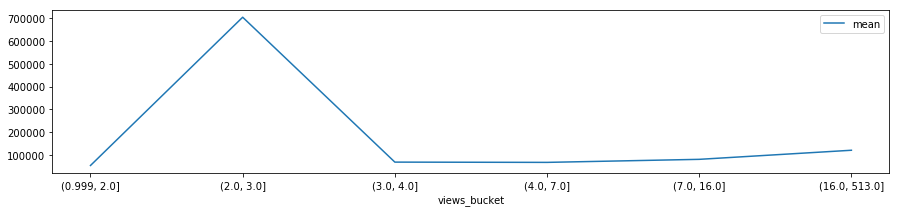

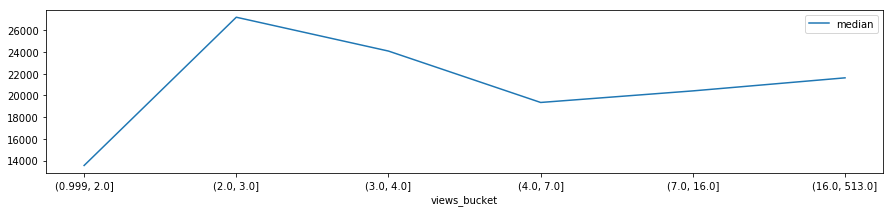

In [117]:
print(rec_grpd.groupby('views_bucket')['volume'].agg(['mean', 'median', 'count']).sort_values('views_bucket').reset_index().plot(x='views_bucket', y='mean', figsize=(15,3)))
print(rec_grpd.groupby('views_bucket')['volume'].agg(['mean', 'median', 'count']).sort_values('views_bucket').reset_index().plot(x='views_bucket', y='median', figsize=(15,3)))

In [165]:
non_recs_orgs = org_performance[~org_performance['org'].isin(rec_grpd['org'].unique())]

print("0 receipt visits:")
print("\tmean volume: ${:,.2f}".format(non_recs_orgs['volume'].mean()))
print("\tmedian volume: ${:,.2f}".format(non_recs_orgs['volume'].median()))
print("1 receipt visit:")
print("\tmean volume: ${:,.2f}".format(rec_grpd[rec_grpd['views']==1]['volume'].mean()))
print("\tmedian volume: ${:,.2f}".format(rec_grpd[rec_grpd['views']==1]['volume'].median()))
print("> 1 receipt visit:")
print("\tmean volume: ${:,.2f}".format(rec_grpd[rec_grpd['views']>1]['volume'].mean()))
print("\tmedian volume: ${:,.2f}".format(rec_grpd[rec_grpd['views']>1]['volume'].median()))
print("> 3 receipt visit:")
print("\tmean volume: ${:,.2f}".format(rec_grpd[rec_grpd['views']>3]['volume'].mean()))
print("\tmedian volume: ${:,.2f}".format(rec_grpd[rec_grpd['views']>3]['volume'].median()))

print()

rec_orgs_mean = rec_grpd['volume'].mean()
rec_orgs_median = rec_grpd['volume'].median()

print("All difference between 0 visits a 1+")
print("\tmean: ${:,.2f}".format(rec_orgs_mean - non_recs_orgs['volume'].mean()))
print("\tmedian: ${:,.2f}".format(rec_orgs_median - non_recs_orgs['volume'].median()))

0 receipt visits:
	mean volume: $28,629.53
	median volume: $4,625.75
1 receipt visit:
	mean volume: $54,567.54
	median volume: $12,803.73
> 1 receipt visit:
	mean volume: $170,940.61
	median volume: $21,072.25
> 3 receipt visit:
	mean volume: $86,790.30
	median volume: $21,301.00

All difference between 0 visits a 1+
	mean: $100,319.48
	median: $13,061.93


There is a clear increase in performance from 1 to > 1 receipt customizations but the effect drops to half at 3. There is a strong spike between 2 and 3 visits but the effect drops off after that. One would assume that 1 or 2 instances of receipt customization is sufficient.

In [133]:
org_rec_pageviews = df[df['message'].str.contains('/receipts/').fillna(False)].copy()
org_rec_pageviews['created_week'] = org_rec_pageviews['created'].dt.isocalendar().week
org_rec_pageviews['created_year'] = org_rec_pageviews['created'].dt.year
org_rec_pageviews['created_week'] = org_rec_pageviews[['created_year', 'created_week']].apply(lambda x: "{}-{}".format(x['created_year'], x['created_week']), axis=1)
org_rec_pageviews.drop('created_year', axis=1, inplace=True)

In [138]:
org_rec_weeks = org_rec_pageviews.groupby(['org'])['created_week'].nunique().reset_index()
org_rec_weeks.columns = ['org', 'rec_weeks']

org_rec_weeks['count'] = org_rec_weeks['org'].apply(get_org_count).fillna(0).astype(int)
org_rec_weeks['volume'] = org_rec_weeks['org'].apply(get_org_volume).fillna(0).astype(float)

In [139]:
org_rec_weeks['views_bucket'] = pd.qcut(org_rec_weeks['rec_weeks'], q=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.], duplicates='drop')
org_rec_weeks.groupby('views_bucket')['volume'].agg(['mean', 'median', 'count']).sort_values('views_bucket').reset_index()

,views_bucket,mean,median,count
0,"(0.999, 2.0]",44615.401568,13565.800,810
1,"(2.0, 3.0]",62707.622874,27396.325,174
2,"(3.0, 4.0]",62158.252828,33083.800,99
3,"(4.0, 5.0]",101374.525556,31159.065,72
4,"(5.0, 12.0]",879638.873333,81209.405,90


Weekly receipts visits
----------------------------------------
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


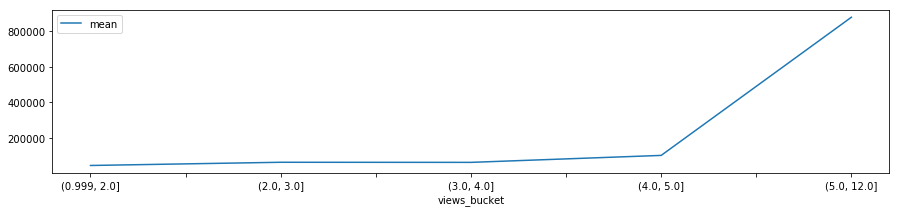

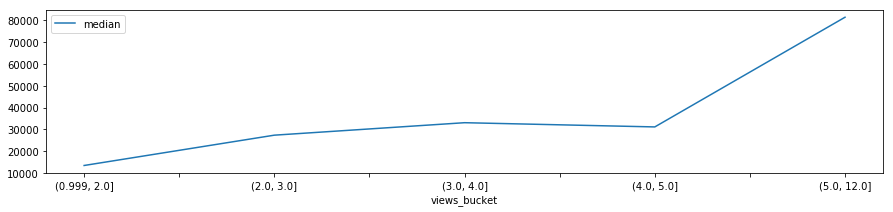

In [140]:
print("Weekly receipts visits")
print("-"*40)
print(org_rec_weeks.groupby('views_bucket')['volume'].agg(['mean', 'median', 'count']).sort_values('views_bucket').reset_index().plot(x='views_bucket', y='mean', figsize=(15,3)))
print(org_rec_weeks.groupby('views_bucket')['volume'].agg(['mean', 'median', 'count']).sort_values('views_bucket').reset_index().plot(x='views_bucket', y='median', figsize=(15,3)))

## goals

In [142]:
org_goals_pageviews = df[df['url cat']=='Goals']

print("{:,} ({:.2f}%) entries".format(len(org_goals_pageviews), (len(org_fields_pageviews) / len(df)) * 100.))
print("{:,} ({:.2f}%) orgs".format(len(org_goals_pageviews['org'].unique()), (len(org_fields_pageviews['org'].unique()) / len(df['org'].unique())) * 100.))

3,649 (0.00%) entries
705 (0.08%) orgs


In [143]:
goals_grpd = org_goals_pageviews.groupby('org')['id'].count().reset_index()
goals_grpd.columns = ['org', 'goals_views']
goals_grpd['count'] = goals_grpd['org'].apply(get_org_count).fillna(0).astype(int)
goals_grpd['volume'] = goals_grpd['org'].apply(get_org_volume).fillna(0).astype(float)

In [144]:
goals_grpd['views_bucket'] = pd.qcut(goals_grpd['goals_views'], q=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.], duplicates='drop')
goals_grpd.groupby('views_bucket')['volume'].agg(['mean', 'median', 'count']).sort_values('views_bucket').reset_index()

,views_bucket,mean,median,count
0,"(0.999, 2.0]",185460.008735,18047.41,419
1,"(2.0, 3.0]",207240.962353,19979.86,68
2,"(3.0, 4.0]",125986.741667,29746.94,36
3,"(4.0, 6.0]",38393.133800,10683.78,50
4,"(6.0, 12.6]",94485.106393,36778.96,61
5,"(12.6, 227.0]",106787.109437,41561.60,71


AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


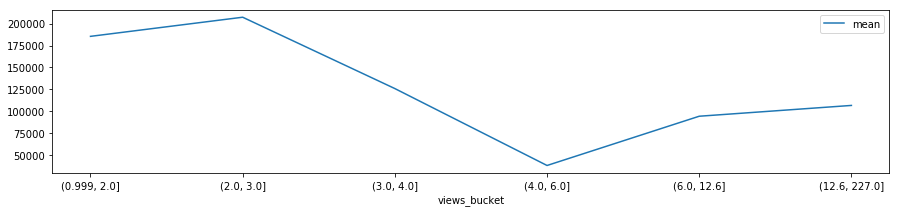

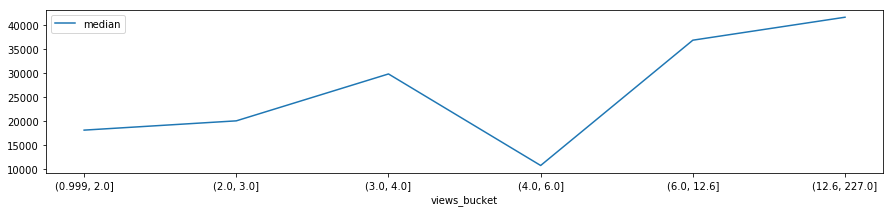

In [145]:
print(goals_grpd.groupby('views_bucket')['volume'].agg(['mean', 'median', 'count']).sort_values('views_bucket').reset_index().plot(x='views_bucket', y='mean', figsize=(15,3)))
print(goals_grpd.groupby('views_bucket')['volume'].agg(['mean', 'median', 'count']).sort_values('views_bucket').reset_index().plot(x='views_bucket', y='median', figsize=(15,3)))

In [163]:
non_goals_orgs = org_performance[~org_performance['org'].isin(goals_grpd['org'].unique())]

print("0 visits:")
print("\tmean volume: ${:,.2f}".format(non_goals_orgs['volume'].mean()))
print("\tmedian volume: ${:,.2f}".format(non_goals_orgs['volume'].median()))
print("1 to 2 goals visits:")
print("\tmean volume: ${:,.2f}".format(goals_grpd[goals_grpd['goals_views']<=2]['volume'].mean()))
print("\tmedian volume: ${:,.2f}".format(goals_grpd[goals_grpd['goals_views']<=2]['volume'].median()))
print("3 to 6 goals visits:")
print("\tmean volume: ${:,.2f}".format(goals_grpd[(goals_grpd['goals_views']>2)&(goals_grpd['goals_views']<=6)]['volume'].mean()))
print("\tmedian volume: ${:,.2f}".format(goals_grpd[(goals_grpd['goals_views']>2)&(goals_grpd['goals_views']<=6)]['volume'].median()))
print("6 to 10 goals visits:")
print("\tmean volume: ${:,.2f}".format(goals_grpd[(goals_grpd['goals_views']>6)&(goals_grpd['goals_views']<=10)]['volume'].mean()))
print("\tmedian volume: ${:,.2f}".format(goals_grpd[(goals_grpd['goals_views']>6)&(goals_grpd['goals_views']<=10)]['volume'].median()))
print("10 to 20 goals visits:")
print("\tmean volume: ${:,.2f}".format(goals_grpd[(goals_grpd['goals_views']>10)&(goals_grpd['goals_views']<=20)]['volume'].mean()))
print("\tmedian volume: ${:,.2f}".format(goals_grpd[(goals_grpd['goals_views']>10)&(goals_grpd['goals_views']<=20)]['volume'].median()))
print("> 20 goals visits:")
print("\tmean volume: ${:,.2f}".format(goals_grpd[(goals_grpd['goals_views']>20)]['volume'].mean()))
print("\tmedian volume: ${:,.2f}".format(goals_grpd[(goals_grpd['goals_views']>20)]['volume'].median()))

print()

all_mean = goals_grpd['volume'].mean()
all_median = goals_grpd['volume'].median()

print("Difference in use:")
print("\tmean: ${:,.2f}".format(all_mean - non_goals_orgs['volume'].mean()))
print("\tmedian: ${:,.2f}".format(all_median - non_goals_orgs['volume'].median()))

0 visits:
	mean volume: $28,510.91
	median volume: $5,012.75
1 to 2 goals visits:
	mean volume: $185,460.01
	median volume: $18,047.41
3 to 6 goals visits:
	mean volume: $133,425.75
	median volume: $18,707.72
6 to 10 goals visits:
	mean volume: $97,345.22
	median volume: $36,799.97
10 to 20 goals visits:
	mean volume: $92,352.98
	median volume: $39,364.85
> 20 goals visits:
	mean volume: $119,862.66
	median volume: $43,325.94

Difference in use:
	mean: $129,788.08
	median: $14,736.25


There is a small number of high performing org's clearly utilizing the goals system but the majority of org's do not appear to use it very much and there is no clear sign that increased engagement is strongly positively correlated to performance. The trend is a little noisy but wavers beyond 0 to 2 visits. 

In [148]:
org_goals_pageviews = org_goals_pageviews.copy()
org_goals_pageviews['created_week'] = org_goals_pageviews['created'].dt.isocalendar().week
org_goals_pageviews['created_year'] = org_goals_pageviews['created'].dt.year
org_goals_pageviews['created_week'] = org_goals_pageviews[['created_year', 'created_week']].apply(lambda x: "{}-{}".format(x['created_year'], x['created_week']), axis=1)
org_goals_pageviews.drop('created_year', axis=1, inplace=True)

In [149]:
org_goals_pageviews = org_goals_pageviews.groupby(['org'])['created_week'].nunique().reset_index()
org_goals_pageviews.columns = ['org', 'goals_weeks']

org_goals_pageviews['count'] = org_goals_pageviews['org'].apply(get_org_count).fillna(0).astype(int)
org_goals_pageviews['volume'] = org_goals_pageviews['org'].apply(get_org_volume).fillna(0).astype(float)

In [150]:
org_goals_pageviews['views_bucket'] = pd.qcut(org_goals_pageviews['goals_weeks'], q=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.], duplicates='drop')
org_goals_pageviews.groupby('views_bucket')['volume'].agg(['mean', 'median', 'count']).sort_values('views_bucket').reset_index()

,views_bucket,mean,median,count
0,"(0.999, 2.0]",161003.442377,17538.415,610
1,"(2.0, 3.0]",90249.652885,44762.800,52
2,"(3.0, 8.0]",202225.650000,54656.920,43


Weekly receipts visits
----------------------------------------
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


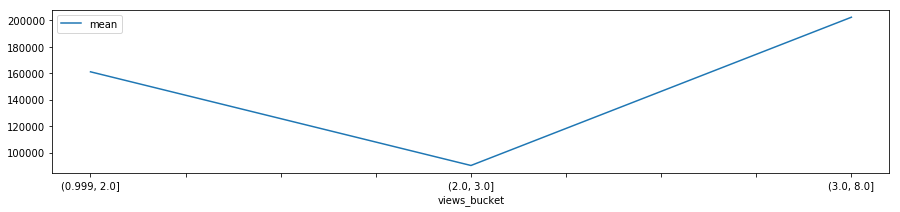

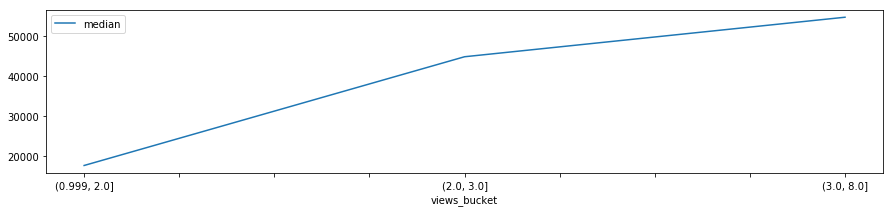

In [151]:
print("Weekly receipts visits")
print("-"*40)
print(org_goals_pageviews.groupby('views_bucket')['volume'].agg(['mean', 'median', 'count']).sort_values('views_bucket').reset_index().plot(x='views_bucket', y='mean', figsize=(15,3)))
print(org_goals_pageviews.groupby('views_bucket')['volume'].agg(['mean', 'median', 'count']).sort_values('views_bucket').reset_index().plot(x='views_bucket', y='median', figsize=(15,3)))